In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as DataLoader
from torch.utils.tensorboard import SummaryWriter

In [3]:
class Discrimiator(nn.Module):
  def __init__(self, img_dim):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Linear(img_dim, 128),
        nn.LeakyReLU(0.1),
        nn.Linear(128, 1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    return self.disc(x)

class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256, img_dim),
        nn.Tanh(), #to make sure the value of pixel values is between -1 and 1 after normalization
    )

  def forward(self,x):
    return self.gen(x)

lr = 3e-4
z_dim = 64
image_dim = 784
batch_size = 32
num_epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:
disc = Discrimiator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn(batch_size, z_dim).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

In [5]:
dataset = datasets.MNIST(root='dataset/', transform=transforms, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17814537.98it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 531492.72it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4443894.88it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10886016.44it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [6]:
loader = DataLoader.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"GAN_MNIST/fake")
writer_real = SummaryWriter(f"GAN_MNIST/real")
step = 0

In [8]:
for epoch in range(num_epochs):
  for batch_idx, (real, _) in enumerate(loader):
    real = real.view(-1, 784).to(device)
    batch_size = real.shape[0]
    noise = torch.randn(batch_size, z_dim).to(device)

    #Train Discriminator
    fake = gen(noise)
    disc_real = disc(real).view(-1)
    #Criterion is -w_n[y_n(ln(x_n)) + (1-y_n)ln(1-x_n)], so first we take yn as 1, next 0 becasue, together makes the negative of target function that is to be maximized, so we minimize the loss to maximize the target fn
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(fake).view(-1)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    lossD = (lossD_real + lossD_fake) / 2
    disc.zero_grad()
    lossD.backward(retain_graph= True)
    opt_disc.step()

    #Train Generator: here, we want to minimize log(1-D(G(z))) but the gradient loss fucntion does train properly, so instead we maximize log(D(G(z)))
    output = disc(fake).view(-1)
    lossG = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    if batch_idx == 0:
      print(
          f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
          Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
      )

      with torch.no_grad():
        fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
        data = real.reshape(-1, 1, 28, 28)
        img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
        img_grid_real = torchvision.utils.make_grid(data, normalize=True)

        writer_fake.add_image(
          "Mnist Fake Images", img_grid_fake, global_step=step
        )
        writer_real.add_image(
          "Mnist Real Images", img_grid_real, global_step=step
        )
        step += 1

Epoch [0/100] Batch 0/1875           Loss D: 0.6254, loss G: 0.6750
Epoch [1/100] Batch 0/1875           Loss D: 0.3979, loss G: 1.3193
Epoch [2/100] Batch 0/1875           Loss D: 0.9132, loss G: 0.7697
Epoch [3/100] Batch 0/1875           Loss D: 0.4674, loss G: 1.1919
Epoch [4/100] Batch 0/1875           Loss D: 0.8292, loss G: 1.1430
Epoch [5/100] Batch 0/1875           Loss D: 0.7406, loss G: 0.9539
Epoch [6/100] Batch 0/1875           Loss D: 0.7307, loss G: 0.8572
Epoch [7/100] Batch 0/1875           Loss D: 0.3938, loss G: 1.4828
Epoch [8/100] Batch 0/1875           Loss D: 0.4608, loss G: 1.1457
Epoch [9/100] Batch 0/1875           Loss D: 0.7251, loss G: 0.9559
Epoch [10/100] Batch 0/1875           Loss D: 0.5913, loss G: 1.0282
Epoch [11/100] Batch 0/1875           Loss D: 0.7426, loss G: 1.0444
Epoch [12/100] Batch 0/1875           Loss D: 0.6642, loss G: 1.3883
Epoch [13/100] Batch 0/1875           Loss D: 0.7326, loss G: 0.8616
Epoch [14/100] Batch 0/1875           Loss D

In [9]:
# Save the model
torch.save(disc.state_dict(), "discriminator.pth")
torch.save(gen.state_dict(), "generator.pth")


In [10]:
with torch.no_grad():
    fake = gen(fixed_noise).reshape(-1, 1, 28, 28)


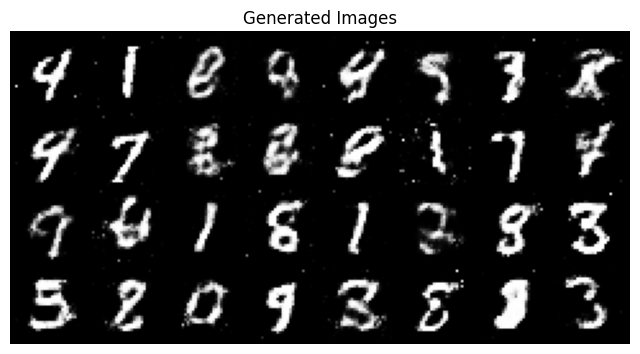

In [11]:
import matplotlib.pyplot as plt
fake_np = fake.cpu().numpy()

# Plot the images using matplotlib
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(torchvision.utils.make_grid(fake, normalize=True).cpu().numpy().transpose((1, 2, 0)))
plt.show()

In [5]:
checkpoint_path = 'generator_100_epochs.pth'

# Initialize the model
modelG = Generator(z_dim,image_dim)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the state dict into the model
modelG.load_state_dict(checkpoint)

# Set the model to evaluation mode (if needed)
modelG.eval()

Generator(
  (gen): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Tanh()
  )
)

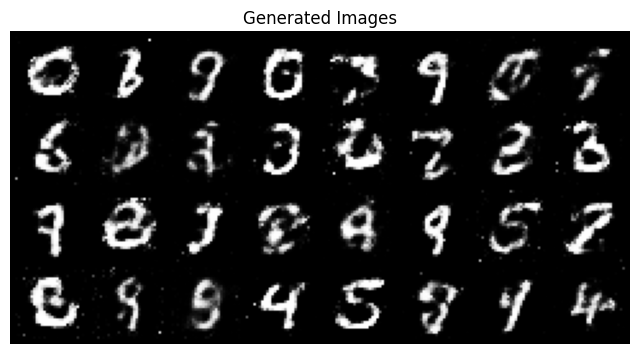

In [8]:
fixed_noise = torch.randn(batch_size, z_dim).to(device)

with torch.no_grad():
    fake = modelG(fixed_noise).reshape(-1, 1, 28, 28)
import matplotlib.pyplot as plt
fake_np = fake.cpu().numpy()

# Plot the images using matplotlib
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(torchvision.utils.make_grid(fake, normalize=True).cpu().numpy().transpose((1, 2, 0)))
plt.show()

In [10]:
checkpoint_path = 'discriminator_100_epochs.pth'

# Initialize the model
modelD = Discrimiator(image_dim)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the state dict into the model
modelD.load_state_dict(checkpoint)

# Set the model to evaluation mode (if needed)
modelD.eval()

Discrimiator(
  (disc): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [15]:
# modelD(fake.view(-1,784))